Populating the interactive namespace from numpy and matplotlib


(-12, 12)

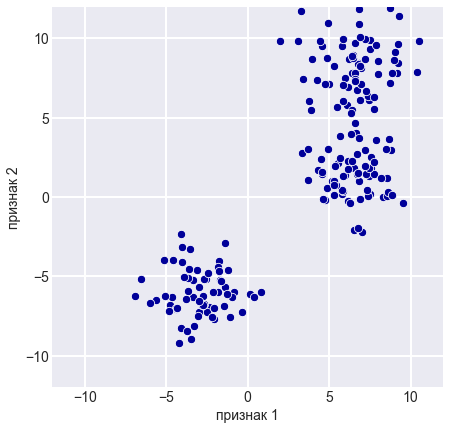

In [3]:
from copy import deepcopy
import numpy as np
%pylab inline
plt.style.use('seaborn-dark')
import warnings
warnings.filterwarnings("ignore") # отключение варнингов
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc('font', size=14)

from sklearn.datasets import make_blobs
seed = 8
n_data = 200
n_clusters = 3
n_centers = 3

blobs, blob_labels = make_blobs(n_samples=n_data, n_features=2,
                                centers=n_centers, random_state=seed,
                                cluster_std=2)

blobs *= 0.75
blobs += 1.1

plt.figure(figsize=(7, 7))

plt.scatter(blobs[:, 0], blobs[:, 1], s=70,
            color='#000099', edgecolors='white', linewidth=0.8)

plt.xlabel('признак 1')
plt.ylabel('признак 2')

plt.grid(lw=2)
plt.xlim([-12, 12])
plt.ylim([-12, 12])

# Реализация алгоритма k-means с выбором кол-ва кластеров
Для реализации была выбрана евклидова метрика, дабы упростить реализацию, однако можно использовать и другие метрики, которые в различных ситуациях могут как улучшить результат, так и ухудшить, следует рассматривать индивидульно для каждой задачи. Но проблема данного алгоритма - надо знать кол-во кластеров до запуска алгоритма, тем не менее есть несколько методов нахождения этого количества, один из них - метод локтя. Его суть в нахождении в графике зависимости качества кластеризации от количества кластеров так называемый "локоть".
Дальше встал вопрос как оценивать качество проделанной кластеризации. В итоге был выбран следующий критерий - сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся.

\begin{equation*}
J(C_k) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k||^{2}
\end{equation*}

Мы хотим, чтобы точки располагались кучно возле центров своих кластеров. Но есть проблема: минимум такого функционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента).
Для решения этого вопроса (выбора числа кластеров) можно воспользоваться такой эвристикой: выбрать то число кластеров, начиная с которого описанный функционал  падает "уже не так быстро". Или более формально:

\begin{equation*}
D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|} \rightarrow \min\limits_k
\end{equation*}

In [7]:
def quality_criteria(blobs, clusters, centrs): # функция критерия качества кластеризации
    func = 0
    func_temp = 0
    size = blobs[:, 0].size
    size_prostr = blobs[0, :].size
    for k in centrs.keys():
        for i in range(size):
            if (clusters[i] == k):
                for j in range(size_prostr):
                    func = func + (blobs[i, j] - centrs[k][j])**2
    return func

In [8]:
def print_image(clust, blob): # функция печати кластеров
    plt.figure(figsize=(7, 7))
    plt.scatter(blob[:, 0], blob[:, 1], s=70, c=clust,
        edgecolors='black', linewidth=0.8) 
    plt.xlabel('признак 1')
    plt.ylabel('признак 2')
    plt.grid(lw=2)
    plt.xlim([-12, 12])
    plt.ylim([-12, 12])
    plt.show()

In [9]:
def centroid_equal(centrs, old_centrs, epsilon): # функция проверки равенства центров кластеров, берем макс разницу по координате
    difference = [abs(np.array(centrs[i]) - np.array(old_centrs[i])) for i in centrs.keys()]
    return (np.max(np.array(difference)) < epsilon)

In [10]:
def calc_distances(blobs, centrs): # функция подсчета расстояний до центроидов
    size_minus_first = blobs[0, :].size - 1
    size = blobs[:, 0].size
    # после этого номер в этом массиве - номер кластера, с которым работаем
    distans = []
    for i in centrs.keys():
        x1_list = blobs[:, 0]
        distance_clust = (x1_list - centrs[i][0])**2
        if (size != 1):
            for k in range(size_minus_first):
                distance_clust = distance_clust + (blobs[:, k + 1] - centrs[i][k + 1])**2
            distance_clust = np.sqrt(distance_clust)
        distans.append(distance_clust)
    return distans

In [11]:
def assignment(blobs, centrs): # функция присваивания точек кластерам
    distans = np.array(calc_distances(blobs, centrs))
    size = blobs[:, 0].size
    closest_cluster = []
    for i in range(size):
        for j in range(len(centrs)):
            if (distans[j, i] == min(distans[:, i])):
                closest_cluster.append(j+1)
                break
    return closest_cluster

In [12]:
def update_centrs(blobs, centrs, clusters): # функция пересчета центров
    size = blobs[:, 0].size
    new_centrs = deepcopy(centrs)
    for i in new_centrs.keys():
        for j in range(blobs[0, :].size):
            new_centrs[i][j] = np.mean([blobs[k][j] for k in range(size) if clusters[k] == i])
    return deepcopy(new_centrs)

In [13]:
def k_means_quality(blobs, n_clusters, random_state): # k_means без картинки, но с оценкой качества
    np.random.seed(seed)
    centrs = {
        i+1: [np.random.randint(min(blobs[:, k]), max(blobs[:, k])) for k in range(blobs[0, :].size)]
        for i in range(n_clusters)
    }
    
    clusters = assignment(blobs, centrs)
    
    #задаем точность, с которой будем считать центроиды равными
    epsilon = 0.001
    
    old_centrs = deepcopy(centrs)
    centrs = deepcopy(update_centrs(blobs, old_centrs, clusters))
    clusters = assignment(blobs, centrs)
    
    while(centroid_equal(centrs, old_centrs, epsilon) != True):
        old_centrs = deepcopy(centrs)
        centrs = deepcopy(update_centrs(blobs, old_centrs, clusters))
        clusters = assignment(blobs, centrs)
        
    return quality_criteria(blobs, clusters, centrs)

In [14]:
def print_quality(list_of_means): # функция рисования графика зависимости критерия качества от количетства кластеров
    list_of_means = np.array(list_of_means)
    plt.plot(list_of_means[:, 1] , list_of_means[:, 0])
    plt.xlabel('number of clusters')
    plt.ylabel('quality measure')
    plt.show()

In [15]:
def minimum(blobs, seed): # функция нахождения минимума функционала из описания алгоритма
    #для полного отчета по оценке качества нужно убрать комменты
    list_of_means = []
    k_means_1n = k_means_quality(blobs, 1, seed)
    #print("quality for 1 cluster", k_means_1n)
    list_of_means.append([k_means_1n / 10, 1])
    k_means_2n = k_means_quality(blobs, 2, seed)
    #print("quality for 2 cluster", k_means_2n)
    list_of_means.append([k_means_2n / 10, 2])
    k_means_3n = k_means_quality(blobs, 3, seed)
    #print("quality for 3 cluster", k_means_3n)
    list_of_means.append([k_means_3n / 10, 3])
    chislitel = abs(k_means_2n - k_means_3n)
    znamenatel = abs(k_means_1n - k_means_2n)
    min = chislitel / znamenatel
    min_index = 2
    for i in range(3, 6):
        k_means_next = k_means_quality(blobs, i + 1, seed)
        #print("quality for", i + 1, "cluster", k_means_3n)
        list_of_means.append([k_means_next / 10, i + 1])
        chislitel = abs(k_means_3n - k_means_next)
        znamenatel = abs(k_means_2n - k_means_3n)
        temp = chislitel / znamenatel
        if (temp < min):
            min = temp
            min_index = i
        k_means_1n = deepcopy(k_means_2n)
        k_means_2n = deepcopy(k_means_3n)
        k_means_3n = deepcopy(k_means_next)
    print_quality(list_of_means)
    return min_index

Рассмотрим пример выбора кол-ва кластеров, для этого нарисуем график зависимости качества кластеризации от кол-ва кластеров: (чтобы не высчитывать много раз k_means, что затратно, будем искать минимум на отрезке, выбранным вручную, конечно для общего случая, надо будет искать минимум дискретно функции.)

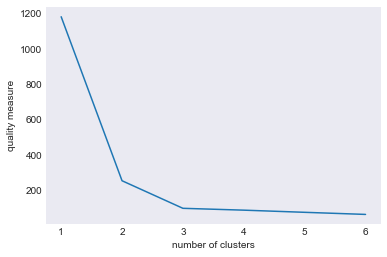

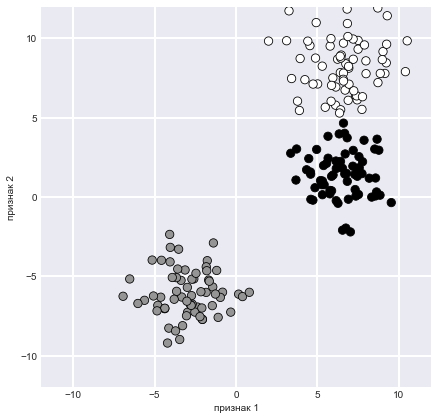

In [13]:
def k_means(blobs, n_clusters, random_state):
    np.random.seed(seed)
    centrs = {
        i+1: [np.random.randint(min(blobs[:, k]), max(blobs[:, k])) for k in range(blobs[0, :].size)]
        for i in np.arange(n_clusters)
    }
    
    clusters = assignment(blobs, centrs)
    
    #задаем точность, с которой будем считать центроиды равными
    epsilon = 0.001
    
    old_centrs = deepcopy(centrs)
    centrs = deepcopy(update_centrs(blobs, old_centrs, clusters))
    clusters = assignment(blobs, centrs)
    
    while(centroid_equal(centrs, old_centrs, epsilon) != True):
        old_centrs = deepcopy(centrs)
        centrs = deepcopy(update_centrs(blobs, old_centrs, clusters))
        clusters = assignment(blobs, centrs)
    print_image(clusters, blobs)
    
k = minimum(blobs, seed)
k_means(blobs, k, seed)

Как мы видим по графику локоть находится в точке 3, следовательно выбираем 3 кластера.

# Везде далее будет использоваться функция k-means из sklearn

Сравним быстродействие K-means и K-means++ на нескольких выборках

12.4 ms ± 253 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


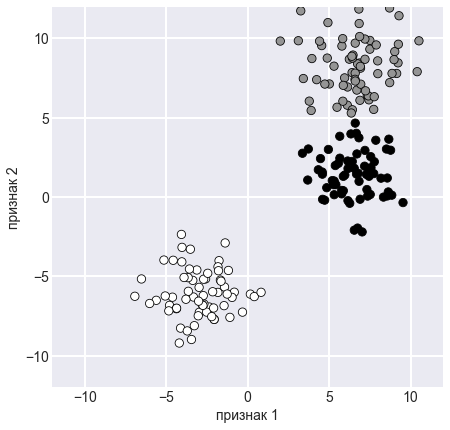

14.7 ms ± 196 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


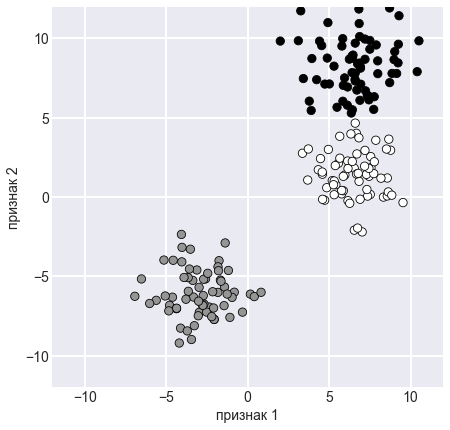

In [16]:
from sklearn.cluster import KMeans

%timeit clusters = KMeans(n_clusters=3, init='random').fit_predict(blobs)
clusters = KMeans(n_clusters=3, init='random').fit_predict(blobs)
print_image(clusters, blobs)

%timeit clusters = KMeans(n_clusters=3, init='k-means++').fit_predict(blobs)
clusters = KMeans(n_clusters=3, init='k-means++').fit_predict(blobs)
print_image(clusters, blobs)

(-12, 12)

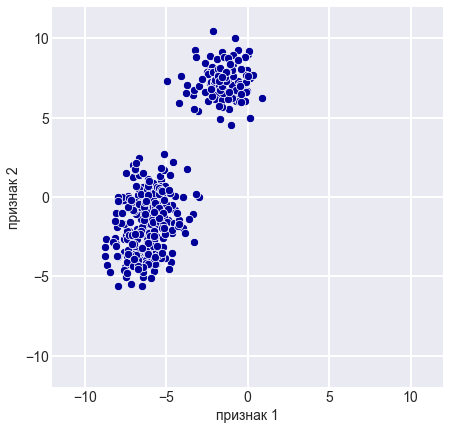

In [17]:
# поменяем выборку и увеличим кол-во элементов
seed = 22
np.random.seed(seed)
blobs2, blob_labels = make_blobs(n_samples=400, n_features=2,
                                centers=3, random_state=seed)
plt.figure(figsize=(7, 7))

plt.scatter(blobs2[:, 0], blobs2[:, 1], s=70,
            color='#000099', edgecolors='white', linewidth=0.8)

plt.xlabel('признак 1')
plt.ylabel('признак 2')

plt.grid(lw=2)
plt.xlim([-12, 12])
plt.ylim([-12, 12])

15.4 ms ± 394 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


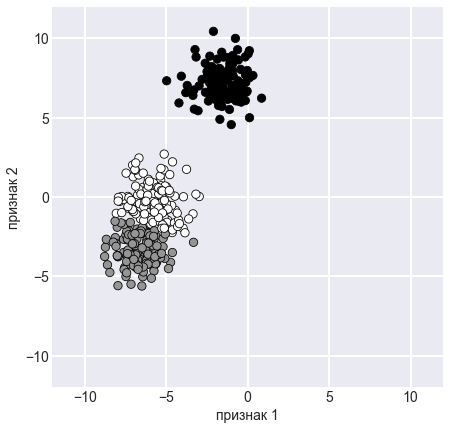

18.3 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


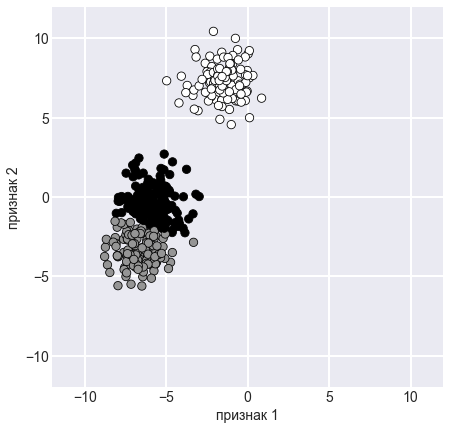

In [18]:
%timeit clusters2 = KMeans(n_clusters=3, init='random').fit_predict(blobs2)
clusters2 = KMeans(n_clusters=3, init='random').fit_predict(blobs2)
print_image(clusters2, blobs2)

%timeit clusters2 = KMeans(n_clusters=3, init='k-means++').fit_predict(blobs2)
clusters2 = KMeans(n_clusters=3, init='k-means++').fit_predict(blobs2)
print_image(clusters2, blobs2)

(-12, 12)

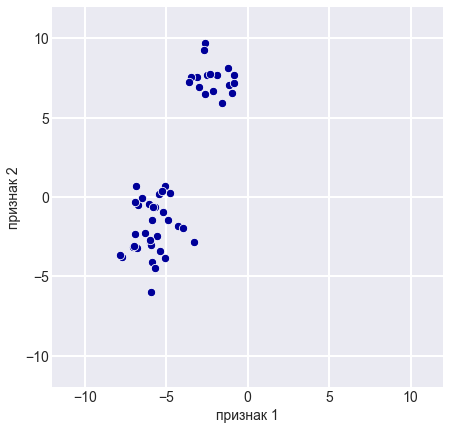

In [19]:
# поменяем выборку и ументшим кол-во элементов
seed = 22
np.random.seed(seed)
blobs2, blob_labels = make_blobs(n_samples=50, n_features=2,
                                centers=3, random_state=seed)
plt.figure(figsize=(7, 7))

plt.scatter(blobs2[:, 0], blobs2[:, 1], s=70,
            color='#000099', edgecolors='white', linewidth=0.8)

plt.xlabel('признак 1')
plt.ylabel('признак 2')

plt.grid(lw=2)
plt.xlim([-12, 12])
plt.ylim([-12, 12])

10.7 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


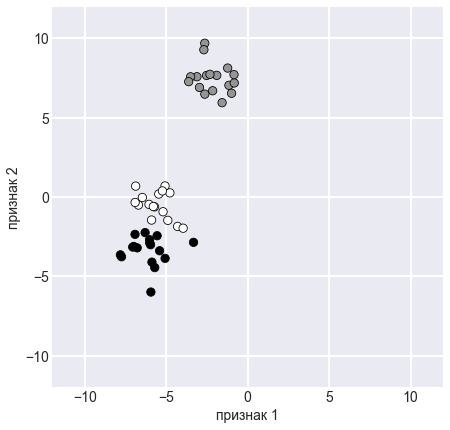

14.1 ms ± 216 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


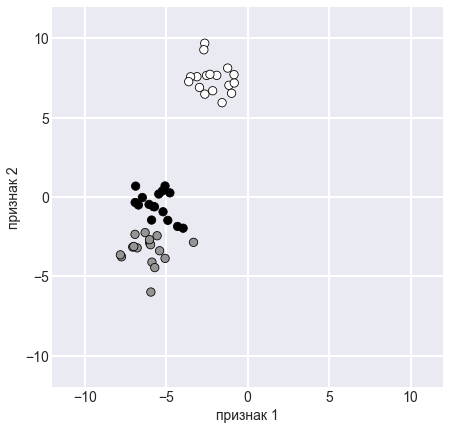

In [20]:
%timeit clusters2 = KMeans(n_clusters=3, init='random').fit_predict(blobs2)
clusters2 = KMeans(n_clusters=3, init='random').fit_predict(blobs2)
print_image(clusters2, blobs2)

%timeit clusters2 = KMeans(n_clusters=3, init='k-means++').fit_predict(blobs2)
clusters2 = KMeans(n_clusters=3, init='k-means++').fit_predict(blobs2)
print_image(clusters2, blobs2)

Как мы видим K-means++ работает совсем немного медленнее, что логично, тк единственное отличие - инициализация начальных центрво кластеров.
## Проверим различия работы k-means и k-means++ на кластерах необычной формы:

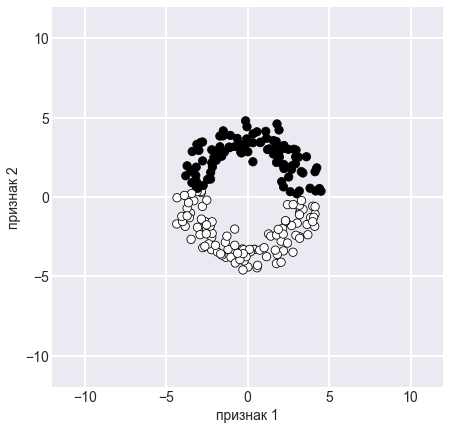

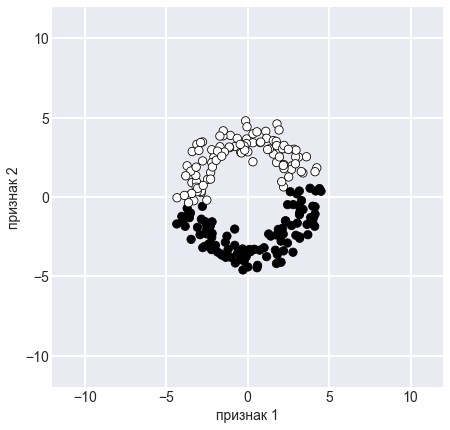

In [71]:
from sklearn.datasets import make_circles

circles, circles_labels = make_circles(n_samples = 200, noise = 0.1)

circles *= 4

clusters2 = KMeans(n_clusters=2, init='random').fit_predict(circles)
print_image(clusters2, circles)

clusters2 = KMeans(n_clusters=2, init='k-means++').fit_predict(circles)
print_image(clusters2, circles)

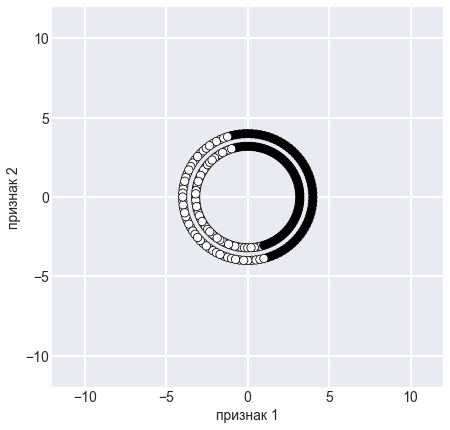

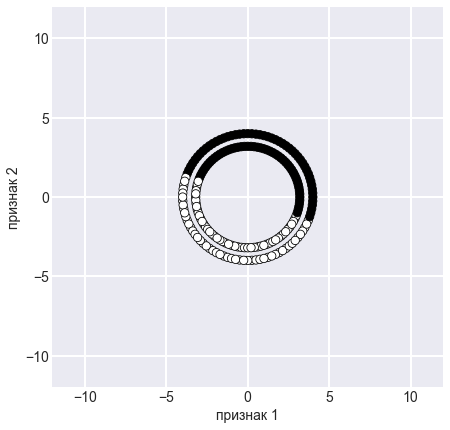

In [72]:
circles, circles_labels = make_circles(n_samples = 200)

circles *= 4

clusters2 = KMeans(n_clusters=2, init='random').fit_predict(circles)
print_image(clusters2, circles)

clusters2 = KMeans(n_clusters=2, init='k-means++').fit_predict(circles)
print_image(clusters2, circles)

Как мы видим, на последнем множестве независимо от выбора начальных центров мы получаем неверный результат, что логично так как центры пересчитываются на центры масс кластеров.

## Вывод:
- Как видно из примеров разницы между k-means и k-means++ в скорости особой нет, во многих случаях такое можно сказать и про сходимость, тем не менее k-means может сойтись в локальный минимум, а k-means++ может их избежать.
- Данный алгоритм очень чувствителен к изначальному заданию количества кластеров, тем не менее существуют алгоритмы нахождения этого количества.

# Перечислим сильные и слабые стороны алгоритма:
## Сильные:

- Сравнительно высокая эффективность при простоте реализации.
- Высокое качество кластеризации.
- Существование множества модификаций.

## Слабые:

- Количество кластеров является параметром алгоритма.
- Чувствительность к начальным условиям.
  Инициализация центров кластеров в значительной степени влияет на результат кластеризации.
- Чувствительность к выбросам и шумам.
  Выбросы, далекие от центров настоящих кластеров, все равно учитываются при вычислении их центров.
- Возможность сходимости к локальному минимуму.
  Итеративный подход не дает гарантии сходимости к оптимальному решению.
- Использование понятия "среднего".
  Алгоритм неприменим к данным, для которых не определено понятие "среднего", например, категориальным данным.

Сложность алгоритма:

\begin{equation*}
{O(ikdn)}
\end{equation*}

где n - количество элементов, k - количество кластеров, d - размерность пространства, i - число итераций